In [72]:
# Import statements
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import acf

In [73]:
# Preprocessing case data
cases21 = pd.read_csv('Data/newCasesPCROnlyBySpecimenDate_ltla_2021.csv')
cases21 = cases21[['date','area_code','area_name','value']]
cases20 = pd.read_csv('Data/newCasesPCROnlyBySpecimenDate_ltla_2020.csv')
cases20 = cases20[['date','area_code','area_name','value']]
cases20_additional = pd.read_csv('Data/ltla_2023-12-14.csv')
cases20_additional.rename(columns={'newCasesBySpecimenDate':'value','areaCode':'area_code','areaName':'area_name'},inplace=True)
cases20_additional.drop(columns='areaType',inplace=True)
cases20_additional = cases20_additional[cases20_additional['area_name'].isin(cases20['area_name'].values)]
cases20 = pd.concat([cases20,cases20_additional])
pop = pd.read_csv('Data/census_estimate.csv')
# Rename columns and take weekly incidence instead of daily
cases = pd.concat([cases20,cases21])
cases['date'] = pd.to_datetime(cases['date'])
cases.set_index('date', inplace=True)
cases21['date'] = pd.to_datetime(cases21['date'])
cases21.set_index('date', inplace=True)
cases20['date'] = pd.to_datetime(cases20['date'])
cases20.set_index('date', inplace=True)
weekly_counts_total = cases.groupby(['area_code','area_name']).rolling(7).sum().reset_index()
weekly_counts_21 = cases21.groupby(['area_code','area_name']).rolling(7).sum().reset_index()
weekly_counts_20 = cases20.groupby(['area_code','area_name']).rolling(7).sum().reset_index()
# Convert incidence to a proportion to allow for cross-LTLA comparison
weekly_counts_21 = pd.merge(weekly_counts_21,pop,on='area_code')
weekly_counts_21['incidence'] = weekly_counts_21['value'] / weekly_counts_21['population']
weekly_counts_20 = pd.merge(weekly_counts_20,pop,on='area_code')
weekly_counts_20['incidence'] = weekly_counts_20['value'] / weekly_counts_20['population']
weekly_counts_total = pd.merge(weekly_counts_total,pop,on='area_code')
weekly_counts_total['incidence'] = weekly_counts_total['value'] / weekly_counts_total['population']
weekly_counts_20 = weekly_counts_20[weekly_counts_20['date']>='2020-06-07']
weekly_counts_21 = weekly_counts_21[weekly_counts_21['date']>='2021-04-07']

In [74]:
# Add in the NHS regions for spatial detrending
npis = pd.read_csv('Data/npis_23Mar_02Dec.csv')
npis = npis[['ltla20nm','region']]
npis.drop_duplicates(inplace=True)

manual_dat = pd.DataFrame({'ltla20nm': ['Wycombe','South Bucks','Chiltern','Aylesbury Vale'], \
                           'region': ['South East', 'South East', 'South East', 'South East']})
npis = pd.concat([npis,manual_dat])

In [75]:
# Add in the NHS regions for spatial detrending
weekly_counts_21 = pd.merge(weekly_counts_21, npis, left_on='area_name', right_on='ltla20nm')
weekly_counts_21.drop(columns='ltla20nm',inplace=True)
weekly_counts_20 = pd.merge(weekly_counts_20, npis, left_on='area_name', right_on='ltla20nm')
weekly_counts_20.drop(columns='ltla20nm',inplace=True)
weekly_counts_total = pd.merge(weekly_counts_total, npis, left_on='area_name', right_on='ltla20nm')
weekly_counts_total.drop(columns='ltla20nm',inplace=True)

In [76]:
# Get the regional mean inicidences and spatially detrend 2021
regional_mean = weekly_counts_21.groupby(['region', 'date'])['incidence'].mean().reset_index()
regional_mean.rename(columns={'incidence': 'regional_mean_incidence'}, inplace=True)
weekly_counts_21 = pd.merge(weekly_counts_21, regional_mean, on=['region', 'date'])
weekly_counts_21['detrended'] = weekly_counts_21['incidence'] - weekly_counts_21['regional_mean_incidence']

In [77]:
# Get the regional mean inicidences and spatially detrend 2020
regional_mean20 = weekly_counts_20.groupby(['region', 'date'])['incidence'].mean().reset_index()
regional_mean20.rename(columns={'incidence': 'regional_mean_incidence'}, inplace=True)
weekly_counts_20 = pd.merge(weekly_counts_20, regional_mean20, on=['region', 'date'])
weekly_counts_20['detrended'] = weekly_counts_20['incidence'] - weekly_counts_20['regional_mean_incidence']

In [78]:
# Same for all cases
# Get the regional mean inicidences and spatially detrend 2020
regional_mean_total = weekly_counts_total.groupby(['region', 'date'])['incidence'].mean().reset_index()
regional_mean_total.rename(columns={'incidence': 'regional_mean_incidence'}, inplace=True)
weekly_counts_total = pd.merge(weekly_counts_total, regional_mean_total, on=['region', 'date'])
weekly_counts_total['detrended'] = weekly_counts_total['incidence'] - weekly_counts_total['regional_mean_incidence']
weekly_counts_total.head()

,area_code,area_name,date,value,population,incidence,region,regional_mean_incidence,detrended
0,E06000001,Hartlepool,2020-06-01,NaN,93836,NaN,North East,NaN,NaN
1,E06000001,Hartlepool,2020-06-02,NaN,93836,NaN,North East,NaN,NaN
2,E06000001,Hartlepool,2020-06-03,NaN,93836,NaN,North East,NaN,NaN
3,E06000001,Hartlepool,2020-06-04,NaN,93836,NaN,North East,NaN,NaN
4,E06000001,Hartlepool,2020-06-05,NaN,93836,NaN,North East,NaN,NaN


In [79]:
# Convert to wide format for ease of future calculations
wide_data = weekly_counts_21.pivot(index='date', columns='area_name', values='detrended')
wide_data20 = weekly_counts_20.pivot(index='date', columns='area_name', values='detrended')
wide_data_total = weekly_counts_total.pivot(index='date', columns='area_name', values='detrended')
wide_data20.head()

area_name,Adur,Allerdale,Amber Valley,Arun,Ashfield,Ashford,Aylesbury Vale,Babergh,Barking and Dagenham,Barnet,...,Woking,Wokingham,Wolverhampton,Worcester,Worthing,Wychavon,Wycombe,Wyre,Wyre Forest,York
date,,,,,,,,,,,,,,,,,,,,,
2020-06-07,-0.000013,-0.000174,0.000010,-0.000038,0.000027,0.000390,0.000019,0.000099,-1.872221e-07,-0.000010,...,-0.000097,-0.000049,0.000041,-0.000002,0.000056,-0.000083,-0.000049,6.113528e-05,-0.000082,-0.000090
2020-06-08,-0.000068,-0.000170,-0.000064,-0.000049,0.000022,0.000336,0.000007,0.000021,-6.039146e-06,-0.000011,...,-0.000069,-0.000042,0.000003,0.000004,0.000055,-0.000095,-0.000030,3.110214e-05,-0.000076,-0.000082
2020-06-09,-0.000057,-0.000126,-0.000074,-0.000044,-0.000042,0.000286,0.000004,-0.000024,-1.320652e-05,-0.000021,...,-0.000058,-0.000042,-0.000006,-0.000030,0.000012,-0.000097,-0.000042,-6.731572e-07,-0.000070,-0.000098
2020-06-10,-0.000071,-0.000135,-0.000099,-0.000049,-0.000067,0.000303,0.000015,-0.000044,-2.923332e-05,-0.000023,...,-0.000056,-0.000052,-0.000021,-0.000020,-0.000014,-0.000097,-0.000034,1.833458e-05,-0.000060,-0.000100
2020-06-11,-0.000064,-0.000127,-0.000108,-0.000042,-0.000077,0.000310,0.000012,-0.000062,-3.257809e-05,-0.000022,...,-0.000050,-0.000016,-0.000003,-0.000013,-0.000026,-0.000097,-0.000034,8.722437e-06,-0.000063,-0.000097


In [80]:
# Function to calculate EWS on a rolling window for each column
def calculate_ews_rolling(wide_data, window_size):
    ews_data = {}
    acf_data = {}
    rolling = wide_data.rolling(window=window_size,center=False, min_periods=1)
    # variance = (wide_data**2).rolling(window=window_size,center=False, min_periods=1).mean()
    variance = rolling.var()
    coefficient_of_variation = rolling.std() / rolling.mean()
    iod = rolling.var() / rolling.mean()
    skew = rolling.skew()
    kurt = rolling.kurt()
    first_diff = rolling.var().diff(axis=0)
    ews_data['variance'] = variance
    ews_data['cov'] = coefficient_of_variation
    ews_data['skew'] = skew
    ews_data['kurt'] = kurt
    ews_data['iod'] = iod
    ews_data['first diff'] = first_diff
    for col in wide_data.columns:
        rolled_group = wide_data[col].rolling(window=window_size, min_periods=1)
        autocorrelation = rolled_group.apply(lambda x: acf(x, nlags=1)[1] if len(x) > 1 else np.nan)
        acf_data[col] = autocorrelation
    ews_data['acf'] = pd.DataFrame.from_dict(acf_data)
    return ews_data

In [81]:
# Get signals short windows
ews_721 = calculate_ews_rolling(wide_data,window_size=7)
ews_1421 = calculate_ews_rolling(wide_data, window_size=14)
ews_720 = calculate_ews_rolling(wide_data20,window_size=7)
ews_1420 = calculate_ews_rolling(wide_data20,window_size=14)
ews_7total = calculate_ews_rolling(wide_data_total,window_size=7)
ews_14total = calculate_ews_rolling(wide_data_total,window_size=14)
# Get signals long windows
ews_1021 = calculate_ews_rolling(wide_data,window_size=10)
ews_3021 = calculate_ews_rolling(wide_data, window_size=30)
ews_3020 = calculate_ews_rolling(wide_data20,window_size=30)
ews_1020 = calculate_ews_rolling(wide_data20,window_size=10)

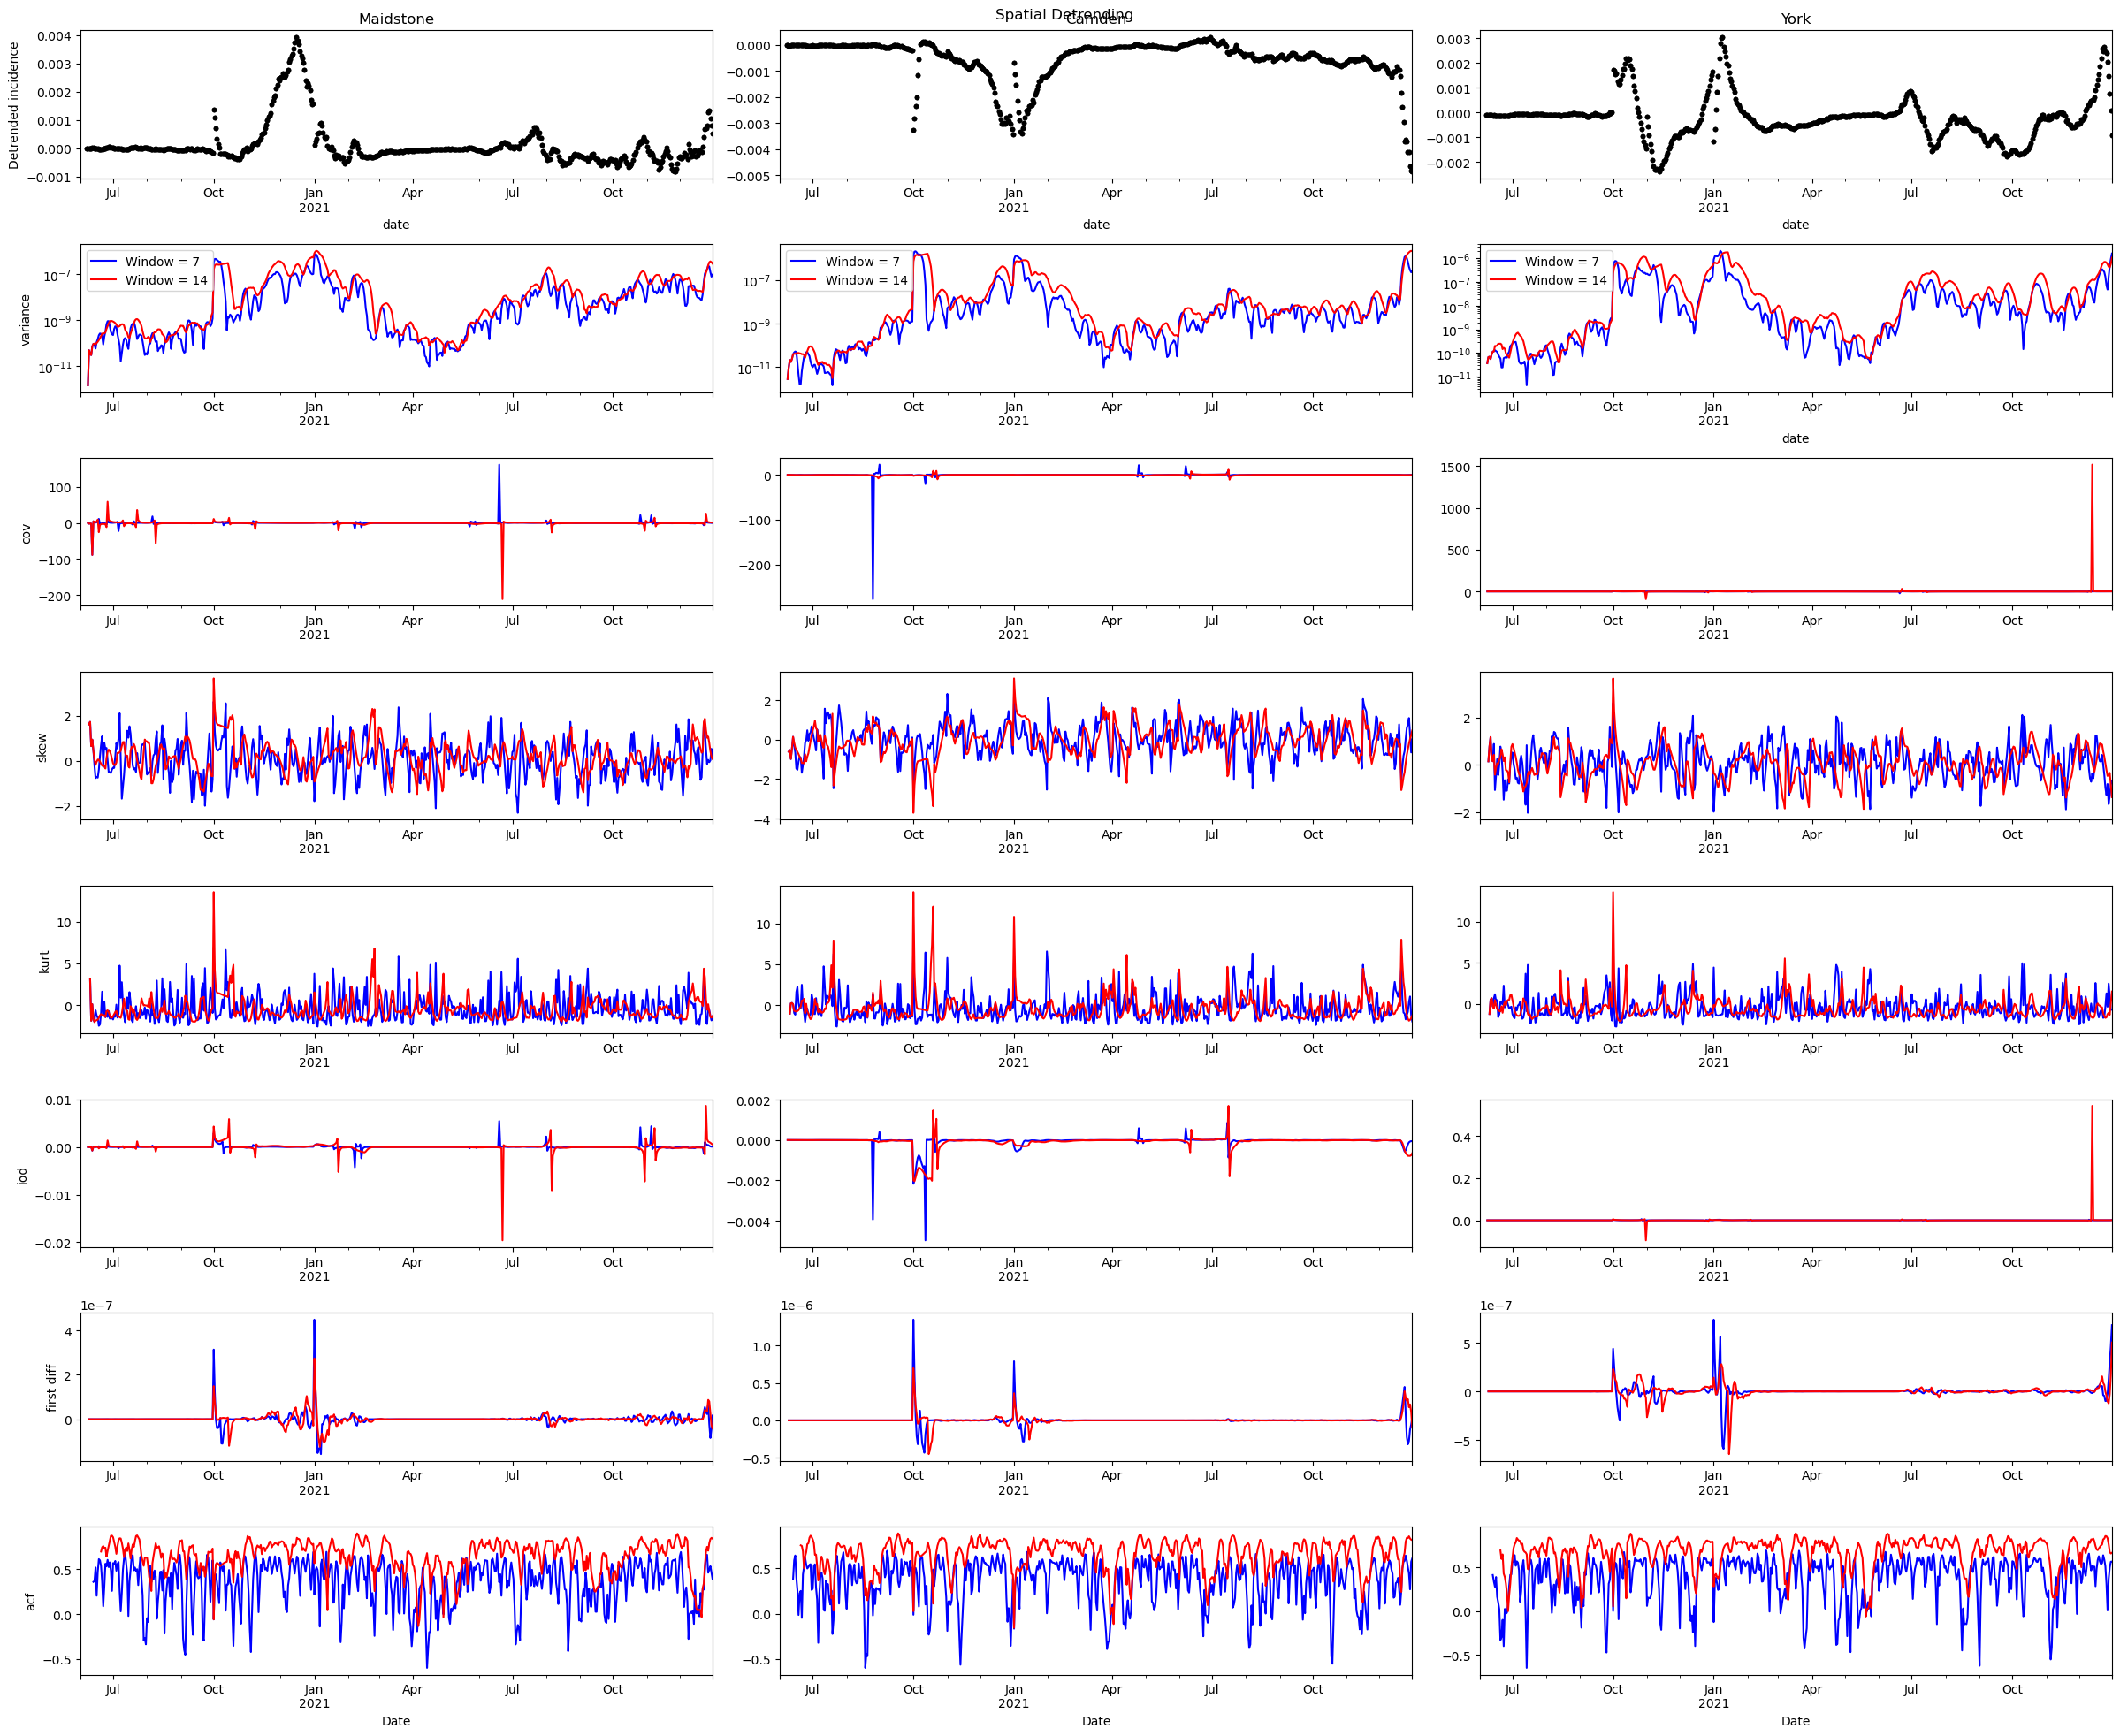

In [82]:
fig, axs = plt.subplots(nrows=len(ews_7total.keys())+1,ncols=3,figsize=(24,20))
for i in range(3):
    wide_data_total['Maidstone'].plot(style='.',ax=axs[0,0],color='black')
    axs[0,0].set_title('Maidstone')
    wide_data_total['Camden'].plot(style='.',ax=axs[0,1],color='black')
    axs[0,1].set_title('Camden')
    wide_data_total['York'].plot(style='.',ax=axs[0,2],color='black')
    axs[0,2].set_title('York')
    axs[0,0].set_ylabel('Detrended incidence')

for i, stat in enumerate(ews_7total.keys()):
    stat_data = ews_7total[stat]
    y_data = stat_data['Maidstone']
    stat_data = ews_14total[stat]
    x_data = stat_data['Maidstone']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+1,0],logy=True,color='blue',label='Window = 7')
        x_data.plot(ax=axs[i+1,0],logy=True,color='red',label='Window = 14')
        axs[i+1,0].legend()
    else:
        y_data.plot(ax=axs[i+1,0],color='blue')
        x_data.plot(ax=axs[i+1,0],color='red')
    axs[i+1,0].set_ylabel(stat)
    axs[i+1,0].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_7total.keys()):
    stat_data = ews_7total[stat]
    y_data = stat_data['Camden']
    stat_data = ews_14total[stat]
    x_data = stat_data['Camden']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+1,1],logy=True,color='blue',label='Window = 7')
        x_data.plot(ax=axs[i+1,1],logy=True,color='red',label='Window = 14')
        axs[i+1,1].legend()
    else:
        y_data.plot(ax=axs[i+1,1],color='blue')
        x_data.plot(ax=axs[i+1,1],color='red')
    axs[i+1,1].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_7total.keys()):
    stat_data = ews_7total[stat]
    y_data = stat_data['York']
    stat_data = ews_14total[stat]
    x_data = stat_data['York']
    if (stat == "variance"):
        y_data.plot(ax=axs[i+1,2],logy=True,color='blue',label='Window = 7')
        x_data.plot(ax=axs[i+1,2],logy=True,color='red',label='Window = 14')
        axs[i+1,2].legend()
    else:
        y_data.plot(ax=axs[i+1,2],color='blue')
        x_data.plot(ax=axs[i+1,2],color='red')
        axs[i+1,2].xaxis.label.set_visible(False)

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date")
    axs[len(axs)-1,i].xaxis.label.set_visible(True)
fig.suptitle('Spatial Detrending')
fig.tight_layout()
plt.savefig("Figures/spatialrolling714.pdf",dpi=2400,bbox_inches='tight')
plt.show()

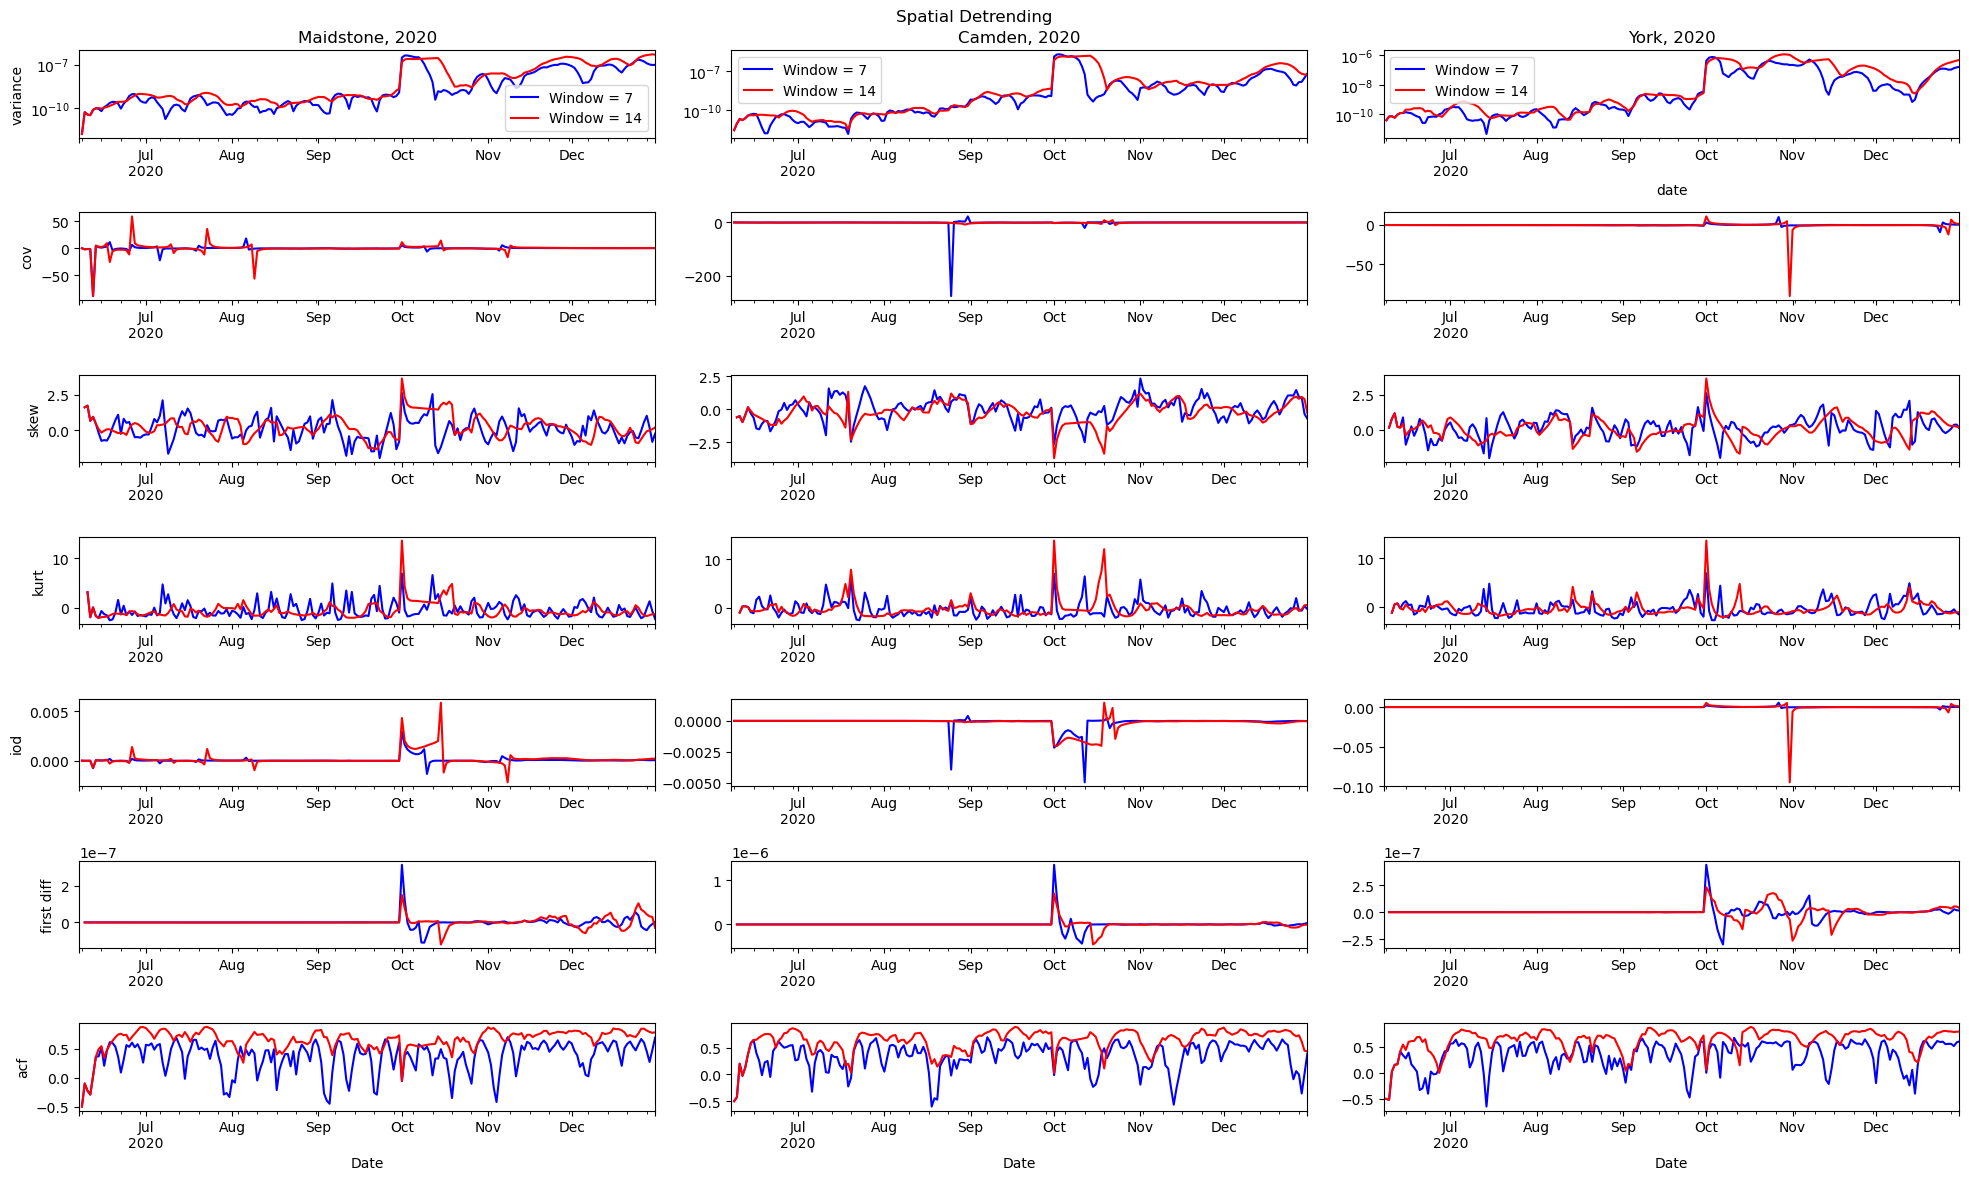

In [15]:
fig, axs = plt.subplots(nrows=len(ews_720.keys()),ncols=3,figsize=(20,12))
for i, stat in enumerate(ews_720.keys()):
    stat_data = ews_720[stat]
    y_data = stat_data['Maidstone']
    stat_data = ews_1420[stat]
    x_data = stat_data['Maidstone']
    if (stat == "variance"):
        y_data.plot(ax=axs[i,0],logy=True,color='blue',label='Window = 7')
        x_data.plot(ax=axs[i,0],logy=True,color='red',label='Window = 14')
        axs[i,0].legend()
        axs[i,0].set_title('Maidstone, 2020')
    else:
        y_data.plot(ax=axs[i,0],color='blue')
        x_data.plot(ax=axs[i,0],color='red')
    axs[i,0].set_ylabel(stat)
    axs[i,0].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_720.keys()):
    stat_data = ews_720[stat]
    y_data = stat_data['Camden']
    stat_data = ews_1420[stat]
    x_data = stat_data['Camden']
    if (stat == "variance"):
        y_data.plot(ax=axs[i,1],logy=True,color='blue',label='Window = 7')
        x_data.plot(ax=axs[i,1],logy=True,color='red',label='Window = 14')
        axs[i,1].legend()
        axs[i,1].set_title('Camden, 2020')
    else:
        y_data.plot(ax=axs[i,1],color='blue')
        x_data.plot(ax=axs[i,1],color='red')
    axs[i,1].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_720.keys()):
    stat_data = ews_720[stat]
    y_data = stat_data['York']
    stat_data = ews_1420[stat]
    x_data = stat_data['York']
    if (stat == "variance"):
        y_data.plot(ax=axs[i,2],logy=True,color='blue',label='Window = 7')
        x_data.plot(ax=axs[i,2],logy=True,color='red',label='Window = 14')
        axs[i,2].legend()
        axs[i,2].set_title('York, 2020')
    else:
        y_data.plot(ax=axs[i,2],color='blue')
        x_data.plot(ax=axs[i,2],color='red')
        axs[i,2].xaxis.label.set_visible(False)

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date")
    axs[len(axs)-1,i].xaxis.label.set_visible(True)
fig.suptitle('Spatial Detrending')
fig.tight_layout()
plt.savefig("Figures/2020spatialrolling714.pdf",dpi=2400,bbox_inches='tight')
plt.show()

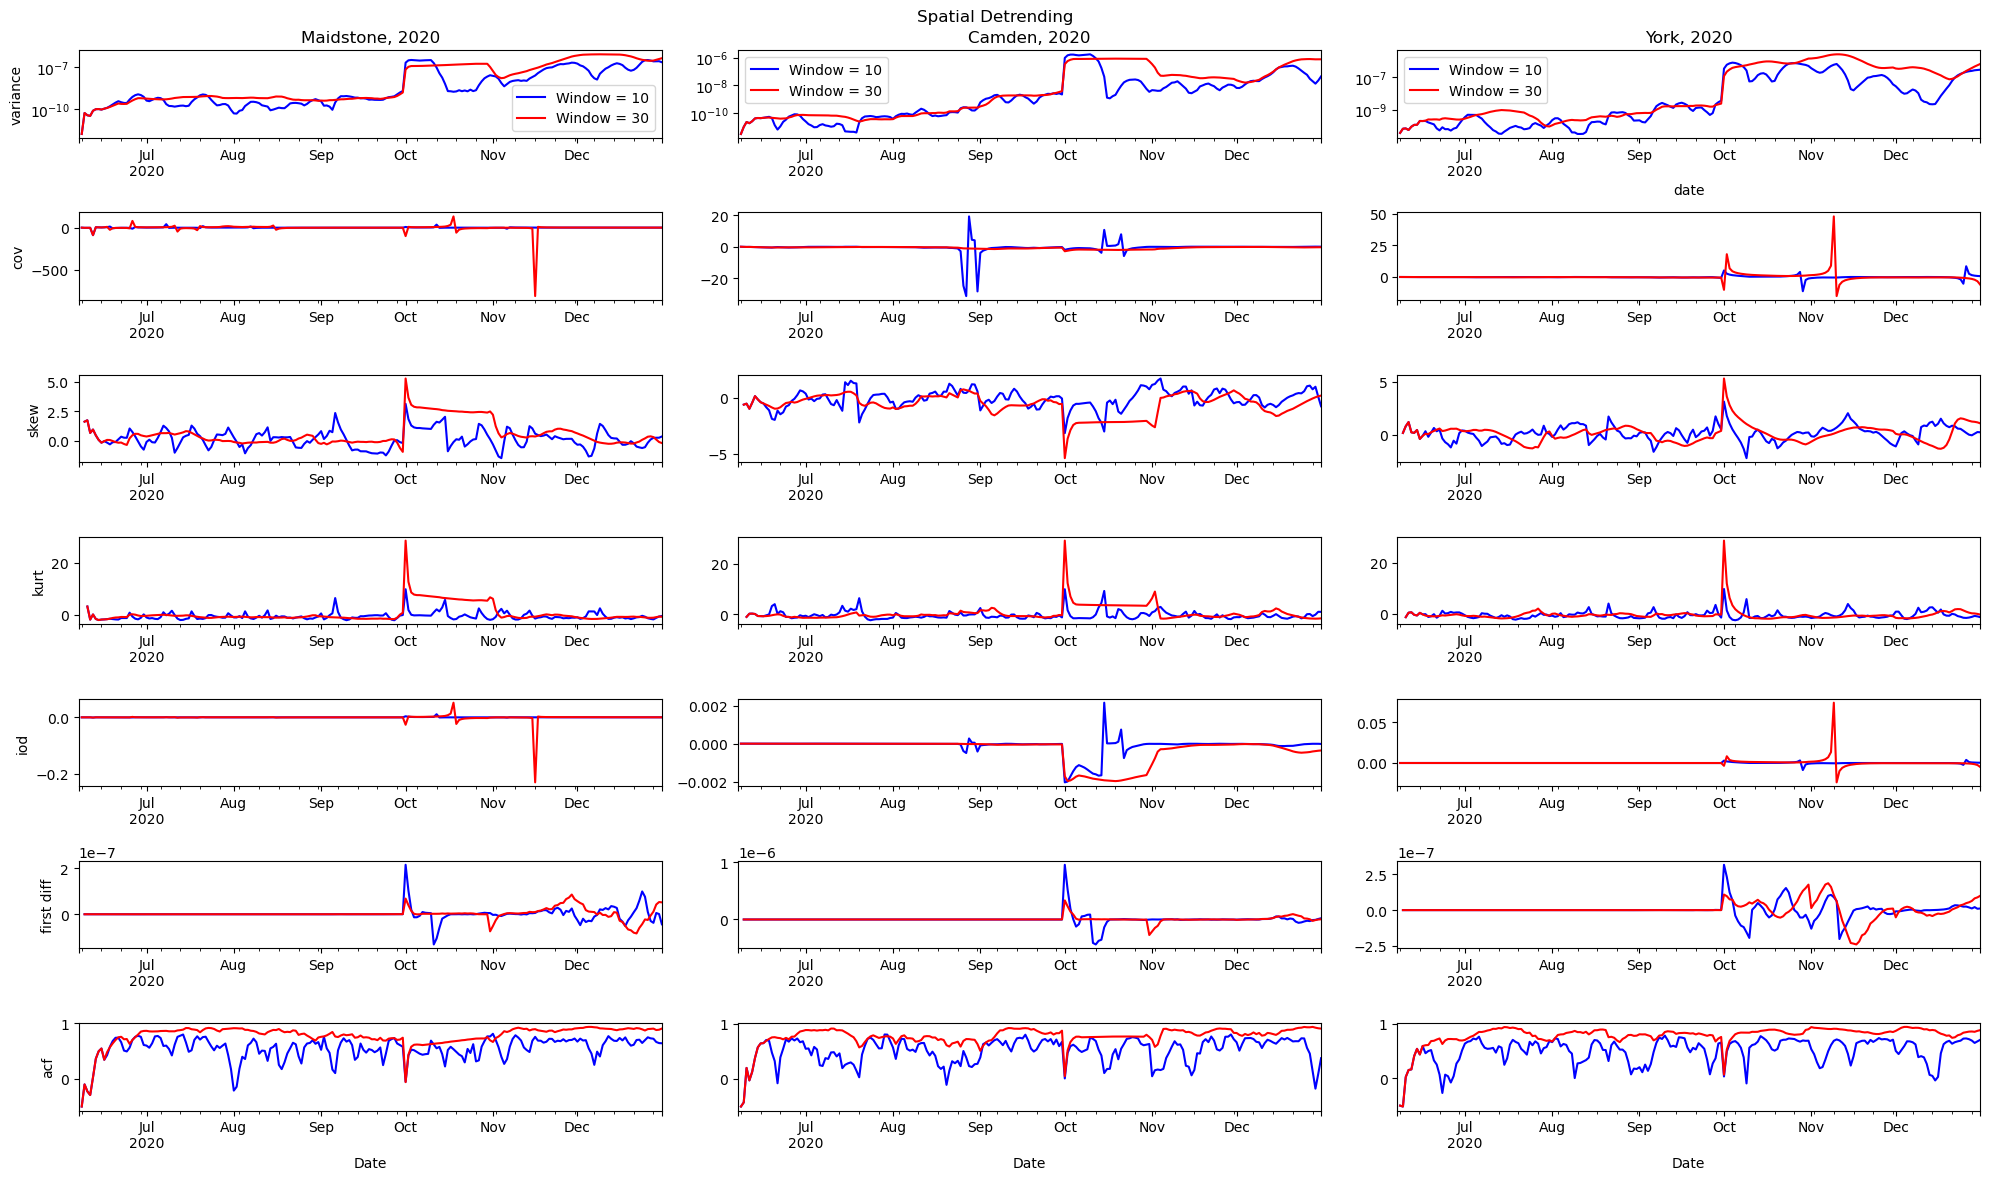

In [17]:
fig, axs = plt.subplots(nrows=len(ews_1020.keys()),ncols=3,figsize=(20,12))
for i, stat in enumerate(ews_1020.keys()):
    stat_data = ews_1020[stat]
    y_data = stat_data['Maidstone']
    stat_data = ews_3020[stat]
    x_data = stat_data['Maidstone']
    if (stat == "variance"):
        y_data.plot(ax=axs[i,0],logy=True,color='blue',label='Window = 10')
        x_data.plot(ax=axs[i,0],logy=True,color='red',label='Window = 30')
        axs[i,0].legend()
        axs[i,0].set_title('Maidstone, 2020')
    else:
        y_data.plot(ax=axs[i,0],color='blue')
        x_data.plot(ax=axs[i,0],color='red')
    axs[i,0].set_ylabel(stat)
    axs[i,0].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_1020.keys()):
    stat_data = ews_1020[stat]
    y_data = stat_data['Camden']
    stat_data = ews_3020[stat]
    x_data = stat_data['Camden']
    if (stat == "variance"):
        y_data.plot(ax=axs[i,1],logy=True,color='blue',label='Window = 10')
        x_data.plot(ax=axs[i,1],logy=True,color='red',label='Window = 30')
        axs[i,1].legend()
        axs[i,1].set_title('Camden, 2020')
    else:
        y_data.plot(ax=axs[i,1],color='blue')
        x_data.plot(ax=axs[i,1],color='red')
    axs[i,1].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_1020.keys()):
    stat_data = ews_1020[stat]
    y_data = stat_data['York']
    stat_data = ews_3020[stat]
    x_data = stat_data['York']
    if (stat == "variance"):
        y_data.plot(ax=axs[i,2],logy=True,color='blue',label='Window = 10')
        x_data.plot(ax=axs[i,2],logy=True,color='red',label='Window = 30')
        axs[i,2].legend()
        axs[i,2].set_title('York, 2020')
    else:
        y_data.plot(ax=axs[i,2],color='blue')
        x_data.plot(ax=axs[i,2],color='red')
        axs[i,2].xaxis.label.set_visible(False)

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date")
    axs[len(axs)-1,i].xaxis.label.set_visible(True)
fig.suptitle('Spatial Detrending')
fig.tight_layout()
plt.savefig("Figures/2020spatialrolling1030.pdf",dpi=2400,bbox_inches='tight')
plt.show()

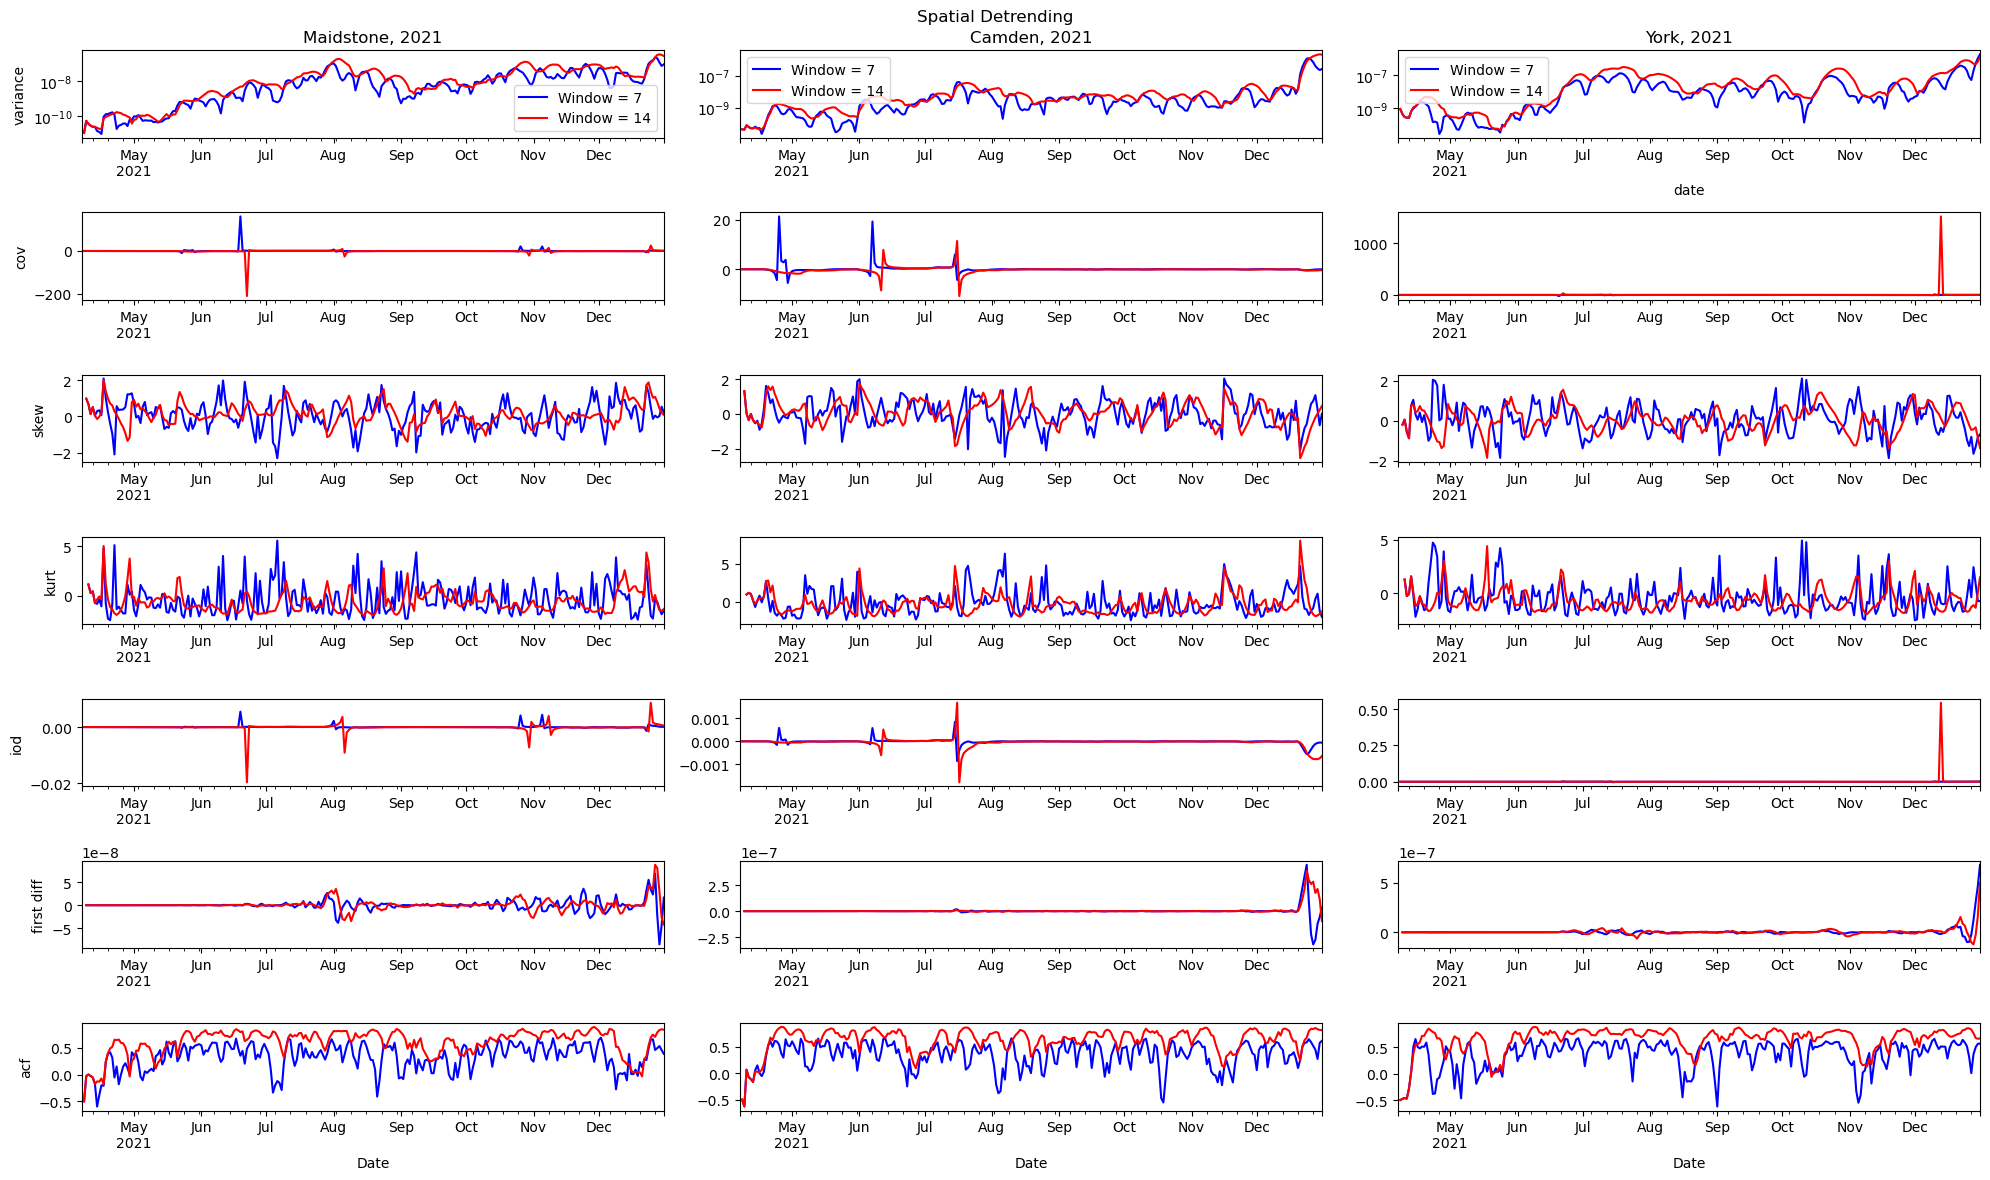

In [18]:
fig, axs = plt.subplots(nrows=len(ews_721.keys()),ncols=3,figsize=(20,12))
for i, stat in enumerate(ews_721.keys()):
    stat_data = ews_721[stat]
    y_data = stat_data['Maidstone']
    stat_data = ews_1421[stat]
    x_data = stat_data['Maidstone']
    if (stat == "variance"):
        y_data.plot(ax=axs[i,0],logy=True,color='blue',label='Window = 7')
        x_data.plot(ax=axs[i,0],logy=True,color='red',label='Window = 14')
        axs[i,0].legend()
        axs[i,0].set_title('Maidstone, 2021')
    else:
        y_data.plot(ax=axs[i,0],color='blue')
        x_data.plot(ax=axs[i,0],color='red')
    axs[i,0].set_ylabel(stat)
    axs[i,0].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_721.keys()):
    stat_data = ews_721[stat]
    y_data = stat_data['Camden']
    stat_data = ews_1421[stat]
    x_data = stat_data['Camden']
    if (stat == "variance"):
        y_data.plot(ax=axs[i,1],logy=True,color='blue',label='Window = 7')
        x_data.plot(ax=axs[i,1],logy=True,color='red',label='Window = 14')
        axs[i,1].legend()
        axs[i,1].set_title('Camden, 2021')
    else:
        y_data.plot(ax=axs[i,1],color='blue')
        x_data.plot(ax=axs[i,1],color='red')
    axs[i,1].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_721.keys()):
    stat_data = ews_721[stat]
    y_data = stat_data['York']
    stat_data = ews_1421[stat]
    x_data = stat_data['York']
    if (stat == "variance"):
        y_data.plot(ax=axs[i,2],logy=True,color='blue',label='Window = 7')
        x_data.plot(ax=axs[i,2],logy=True,color='red',label='Window = 14')
        axs[i,2].legend()
        axs[i,2].set_title('York, 2021')
    else:
        y_data.plot(ax=axs[i,2],color='blue')
        x_data.plot(ax=axs[i,2],color='red')
        axs[i,2].xaxis.label.set_visible(False)

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date")
    axs[len(axs)-1,i].xaxis.label.set_visible(True)
fig.suptitle('Spatial Detrending')
fig.tight_layout()
plt.savefig("Figures/2021spatialrolling714.pdf",dpi=2400,bbox_inches='tight')
plt.show()

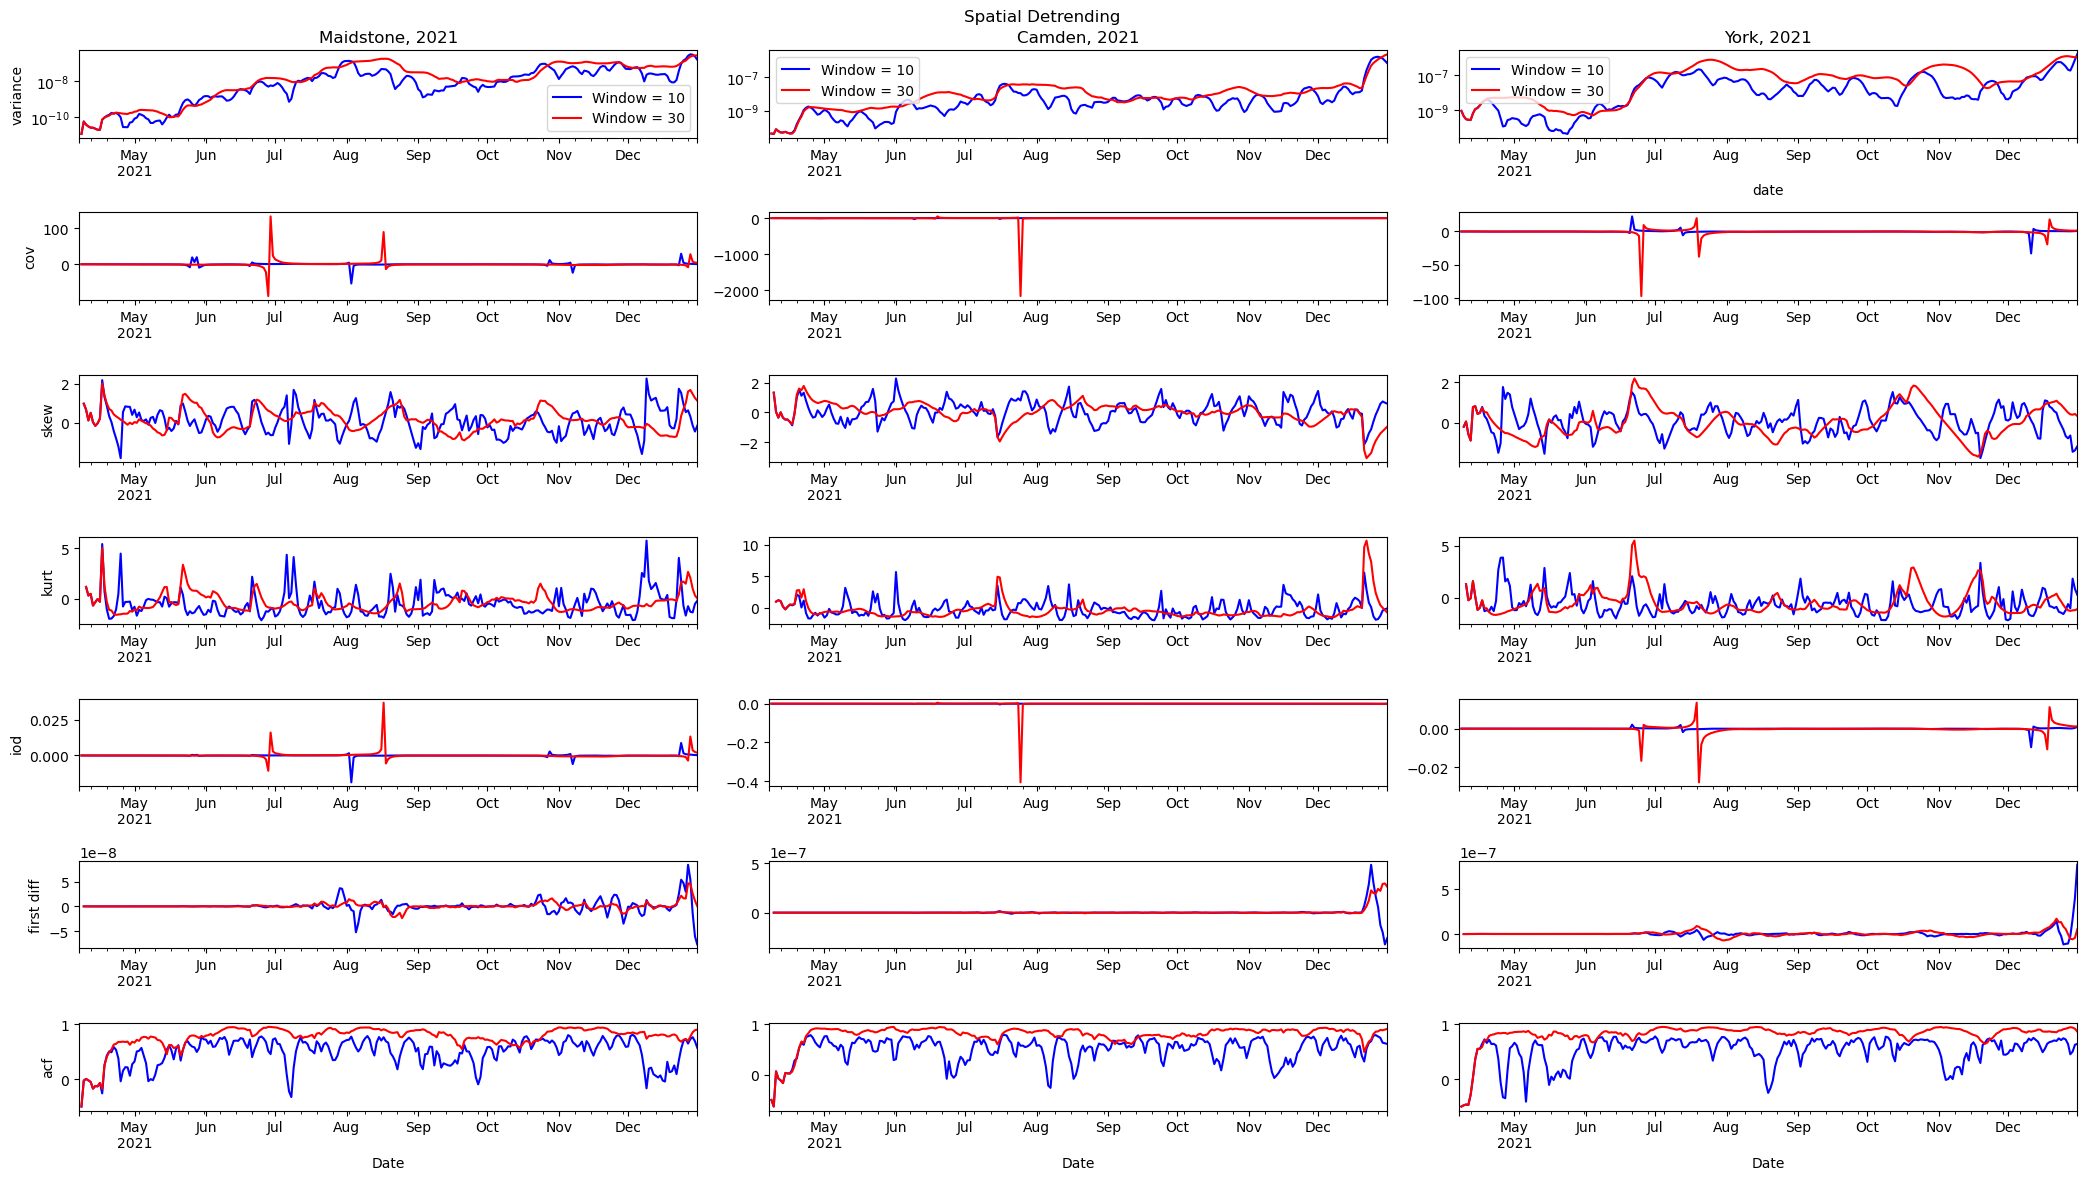

In [20]:
fig, axs = plt.subplots(nrows=len(ews_1021.keys()),ncols=3,figsize=(21,12))
for i, stat in enumerate(ews_1021.keys()):
    stat_data = ews_1021[stat]
    y_data = stat_data['Maidstone']
    stat_data = ews_3021[stat]
    x_data = stat_data['Maidstone']
    if (stat == "variance"):
        y_data.plot(ax=axs[i,0],logy=True,color='blue',label='Window = 10')
        x_data.plot(ax=axs[i,0],logy=True,color='red',label='Window = 30')
        axs[i,0].legend()
        axs[i,0].set_title('Maidstone, 2021')
    else:
        y_data.plot(ax=axs[i,0],color='blue')
        x_data.plot(ax=axs[i,0],color='red')
    axs[i,0].set_ylabel(stat)
    axs[i,0].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_1021.keys()):
    stat_data = ews_1021[stat]
    y_data = stat_data['Camden']
    stat_data = ews_3021[stat]
    x_data = stat_data['Camden']
    if (stat == "variance"):
        y_data.plot(ax=axs[i,1],logy=True,color='blue',label='Window = 10')
        x_data.plot(ax=axs[i,1],logy=True,color='red',label='Window = 30')
        axs[i,1].legend()
        axs[i,1].set_title('Camden, 2021')
    else:
        y_data.plot(ax=axs[i,1],color='blue')
        x_data.plot(ax=axs[i,1],color='red')
    axs[i,1].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_1021.keys()):
    stat_data = ews_1021[stat]
    y_data = stat_data['York']
    stat_data = ews_3021[stat]
    x_data = stat_data['York']
    if (stat == "variance"):
        y_data.plot(ax=axs[i,2],logy=True,color='blue',label='Window = 10')
        x_data.plot(ax=axs[i,2],logy=True,color='red',label='Window = 30')
        axs[i,2].legend()
        axs[i,2].set_title('York, 2021')
    else:
        y_data.plot(ax=axs[i,2],color='blue')
        x_data.plot(ax=axs[i,2],color='red')
        axs[i,2].xaxis.label.set_visible(False)

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date")
    axs[len(axs)-1,i].xaxis.label.set_visible(True)
fig.suptitle('Spatial Detrending')
fig.tight_layout()
plt.savefig("Figures/2021spatialrolling1030.pdf",dpi=2400,bbox_inches='tight')
plt.show()

In [ ]:
from itertools import combinations, groupby
from operator import itemgetter

def long_run_averages(stat_data, ltla):
    standardised = stat_data[ltla].values
    n = len(standardised)
    running_mean = np.zeros(n)
    running_std= np.zeros(n)
    for j in range(n):
        running_mean[j] = np.nanmean(standardised[1:j+1])
        running_std[j] = np.nanstd(standardised[1:j+1])
        
    return running_std, running_mean


def two_sigma(ews, start, end, consecutive_length = 2):
    start = np.datetime64(start)
    end = np.datetime64(end)
    two_sigma_stat = {}
    for stat in ews.keys():
        stat_data = ews[stat]
        mean_val
    indices_greater = [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])>(mean_val+2*std_val)[i] ]
    indices_smaller =  [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])<(mean_val-2*std_val)[i] ]
    all_indices = np.setdiff1d(np.unique(indices_greater + indices_smaller ),[1])    
    try:
        if consecutive_length ==1:
            start = all_indices[0]
            finish = all_indices[-1]
            total = len(all_indices)
            return start, finish, total
        else:
            smallest_diff = np.min(np.diff(all_indices))

            if smallest_diff <2:
                index = []
                for k, g in groupby(enumerate(all_indices), lambda x:x[0]-x[1]):
                    group = list(map(itemgetter(1), g))
                    if len(group)>=consecutive_length:
                        index = index+(group)
                start = index[0]
                finish = index[-1]
                total = len(index)
                return start, finish, total
    except:
        return np.nan

In [34]:
# Function to calculate K-tau over moving window
def kendall_tau_ews_moving(df, start, end, ltla):
    kendall_tau_stat = {}
    start = np.datetime64(start)
    end = np.datetime64(end)
    for stat in df.keys():
        ktau = {}
        ltla_data = df[stat]
        ltla_data = ltla_data[ltla].reset_index()
        ktau[ltla] = ltla_data.loc[(ltla_data['date']>=start) & (ltla_data['date']<=end)].corr(method = 'kendall').loc['date',ltla]
        
        kendall_tau_stat[stat] = pd.DataFrame(ktau, index = [0])
    return kendall_tau_stat

In [36]:
from scipy.stats import iqr

def silvermans(x):
    each_loc = np.zeros(np.shape(x)[1])
    for index_x in range(np.shape(x)[1]):
        each_loc[index_x] = 1.06*np.minimum(np.nanstd(x[:,index_x]), 
                                           iqr(x[:,index_x], 
                                                nan_policy='omit')/1.34)*((len(x[:,index_x]))**(-1/5))
    return each_loc

In [79]:
# Preprocessing case data
cases21 = pd.read_csv('Data/newCasesPCROnlyBySpecimenDate_ltla_2021.csv')
cases21 = cases21[['date','area_code','area_name','value']]
cases20 = pd.read_csv('Data/newCasesPCROnlyBySpecimenDate_ltla_2020.csv')
cases20 = cases20[['date','area_code','area_name','value']]
pop = pd.read_csv('Data/census_estimate.csv')
# Rename columns and take weekly incidence instead of daily
cases21['date'] = pd.to_datetime(cases21['date'])
cases21 = cases21[cases21['date'] >= '2021-04-01']
cases21.set_index('date', inplace=True)
cases20['date'] = pd.to_datetime(cases20['date'])
cases20.set_index('date', inplace=True)
weekly_counts_21 = cases21.groupby(['area_code','area_name']).resample('W')['value'].sum().reset_index()
weekly_counts_20 = cases20.groupby(['area_code','area_name']).resample('W')['value'].sum().reset_index()
# Convert incidence to a proportion to allow for cross-LTLA comparison
weekly_counts_21 = pd.merge(weekly_counts_21,pop,on='area_code')
weekly_counts_21['incidence'] = weekly_counts_21['value'] / weekly_counts_21['population']
weekly_counts_20 = pd.merge(weekly_counts_20,pop,on='area_code')
weekly_counts_20['incidence'] = weekly_counts_20['value'] / weekly_counts_20['population']
# Convert to wide format for ease of future calculations
wide_data21_uniform = weekly_counts_21.pivot(index='date', columns='area_name', values='incidence')
wide_data20_uniform = weekly_counts_20.pivot(index='date', columns='area_name', values='incidence')
wide_data20_uniform.head()

area_name,Adur,Allerdale,Amber Valley,Arun,Ashfield,Ashford,Aylesbury Vale,Babergh,Barking and Dagenham,Barnet,...,Woking,Wokingham,Wolverhampton,Worcester,Worthing,Wychavon,Wycombe,Wyre,Wyre Forest,York
date,,,,,,,,,,,,,,,,,,,,,
2020-06-07,0.000093,0.000031,0.000217,0.000068,0.000234,0.000496,0.000126,0.000205,0.000042,0.000033,...,0.00001,0.000057,0.000163,0.00012,0.000163,0.000038,0.000058,0.000265,0.000040,0.000081
2020-06-14,0.000047,0.000051,0.000070,0.000019,0.000047,0.000374,0.000087,0.000011,0.000037,0.000015,...,0.00004,0.000057,0.000087,0.00012,0.000000,0.000038,0.000029,0.000142,0.000030,0.000081
2020-06-21,0.000031,0.000031,0.000078,0.000031,0.000039,0.000412,0.000082,0.000032,0.000023,0.000020,...,0.00008,0.000006,0.000091,0.00005,0.000054,0.000015,0.000052,0.000150,0.000049,0.000066
2020-06-28,0.000031,0.000010,0.000047,0.000025,0.000031,0.000282,0.000024,0.000032,0.000056,0.000015,...,0.00008,0.000029,0.000064,0.00003,0.000009,0.000038,0.000052,0.000071,0.000020,0.000019
2020-07-05,0.000016,0.000041,0.000031,0.000000,0.000055,0.000237,0.000097,0.000000,0.000028,0.000038,...,0.00011,0.000023,0.000049,0.00005,0.000027,0.000015,0.000075,0.000035,0.000020,0.000033


In [80]:
detrended_uniform_1020 = wide_data20_uniform - wide_data20_uniform.rolling(window=10,center=False).mean()
detrended_uniform_520 = wide_data20_uniform - wide_data20_uniform.rolling(window=5,center=False).mean()
detrended_uniform_1021 = wide_data21_uniform - wide_data21_uniform.rolling(window=10,center=False).mean()
detrended_uniform_521 = wide_data21_uniform - wide_data21_uniform.rolling(window=5,center=False).mean()
detrended_uniform_520.head()

area_name,Adur,Allerdale,Amber Valley,Arun,Ashfield,Ashford,Aylesbury Vale,Babergh,Barking and Dagenham,Barnet,...,Woking,Wokingham,Wolverhampton,Worcester,Worthing,Wychavon,Wycombe,Wyre,Wyre Forest,York
date,,,,,,,,,,,,,,,,,,,,,
2020-06-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-05,-0.000028,0.000008,-0.000057,-0.000029,-0.000026,-0.000124,0.000014,-0.000056,-0.000009,0.000014,...,0.000046,-0.000011,-0.000042,-0.000024,-0.000023,-0.000014,0.000022,-0.000097,-0.000012,-0.000023


In [81]:
detrended_gaussian_521 = wide_data21_uniform - wide_data21_uniform.rolling(window=5,win_type='gaussian',
                                                                      center=False).mean(std=np.mean(silvermans(wide_data21_uniform.values)))
detrended_gaussian_520 = wide_data20_uniform - wide_data20_uniform.rolling(window=5,win_type='gaussian',
                                                                      center=False).mean(std=np.mean(silvermans(wide_data20_uniform.values)))

In [82]:
# Get signals
ews_521_u = calculate_ews_rolling(detrended_uniform_521,window_size=5)
ews_1021_u = calculate_ews_rolling(detrended_uniform_1021, window_size=10)
ews_1020_u = calculate_ews_rolling(detrended_uniform_1020,window_size=10)
ews_520_u = calculate_ews_rolling(detrended_uniform_520,window_size=5)
ews_520_g = calculate_ews_rolling(detrended_gaussian_520,window_size=5)
ews_521_g = calculate_ews_rolling(detrended_gaussian_521,window_size=5)

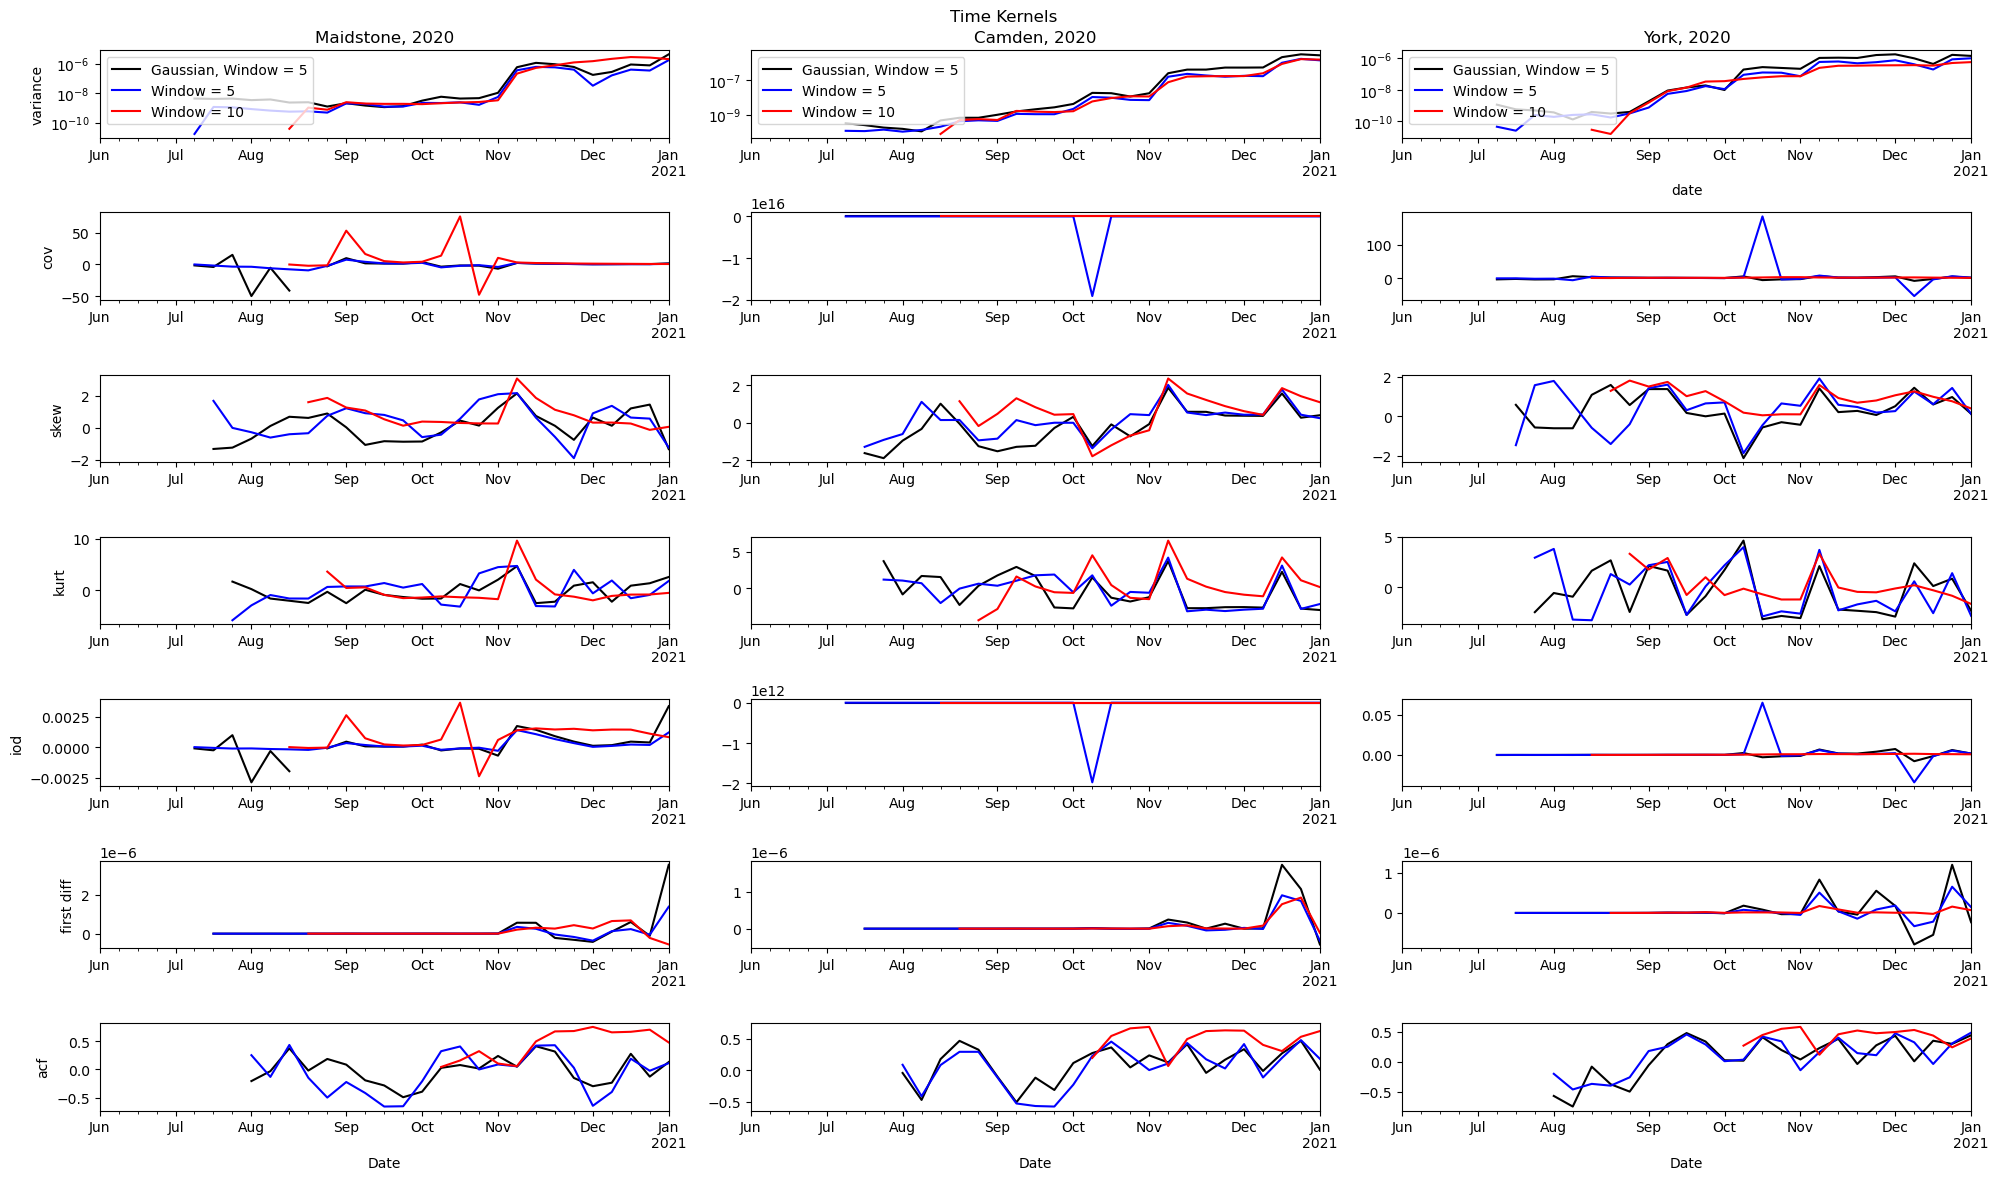

In [84]:
fig, axs = plt.subplots(nrows=len(ews_520_u.keys()),ncols=3,figsize=(20,12))
for i, stat in enumerate(ews_520_u.keys()):
    stat_data = ews_520_u[stat]
    y_data = stat_data['Maidstone']
    stat_data = ews_1020_u[stat]
    x_data = stat_data['Maidstone']
    stat_data = ews_520_g[stat]
    z_data = stat_data['Maidstone']
    if (stat == "variance"):
        z_data.plot(ax=axs[i,0],logy=True,color='black',label='Gaussian, Window = 5')
        y_data.plot(ax=axs[i,0],logy=True,color='blue',label='Window = 5')
        x_data.plot(ax=axs[i,0],logy=True,color='red',label='Window = 10')
        axs[i,0].legend()
        axs[i,0].set_title('Maidstone, 2020')
    else:
        z_data.plot(ax=axs[i,0],color='black')
        y_data.plot(ax=axs[i,0],color='blue')
        x_data.plot(ax=axs[i,0],color='red')
    axs[i,0].set_ylabel(stat)
    axs[i,0].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_520_u.keys()):
    stat_data = ews_520_u[stat]
    y_data = stat_data['Camden']
    stat_data = ews_1020_u[stat]
    x_data = stat_data['Camden']
    stat_data = ews_520_g[stat]
    z_data = stat_data['Camden']
    if (stat == "variance"):
        z_data.plot(ax=axs[i,1],logy=True,color='black',label='Gaussian, Window = 5')
        y_data.plot(ax=axs[i,1],logy=True,color='blue',label='Window = 5')
        x_data.plot(ax=axs[i,1],logy=True,color='red',label='Window = 10')
        axs[i,1].legend()
        axs[i,1].set_title('Camden, 2020')
    else:
        z_data.plot(ax=axs[i,1],color='black')
        y_data.plot(ax=axs[i,1],color='blue')
        x_data.plot(ax=axs[i,1],color='red')
    axs[i,1].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_520_u.keys()):
    stat_data = ews_520_u[stat]
    y_data = stat_data['York']
    stat_data = ews_1020_u[stat]
    x_data = stat_data['York']
    stat_data = ews_520_g[stat]
    z_data = stat_data['York']
    if (stat == "variance"):
        z_data.plot(ax=axs[i,2],logy=True,color='black',label='Gaussian, Window = 5')
        y_data.plot(ax=axs[i,2],logy=True,color='blue',label='Window = 5')
        x_data.plot(ax=axs[i,2],logy=True,color='red',label='Window = 10')
        axs[i,2].legend()
        axs[i,2].set_title('York, 2020')
    else:
        z_data.plot(ax=axs[i,2],color='black')
        y_data.plot(ax=axs[i,2],color='blue')
        x_data.plot(ax=axs[i,2],color='red')
        axs[i,2].xaxis.label.set_visible(False)

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date")
    axs[len(axs)-1,i].xaxis.label.set_visible(True)
fig.suptitle('Time Kernels')
fig.tight_layout()
plt.savefig("Figures/2020time.pdf",dpi=2400,bbox_inches='tight')
plt.show()

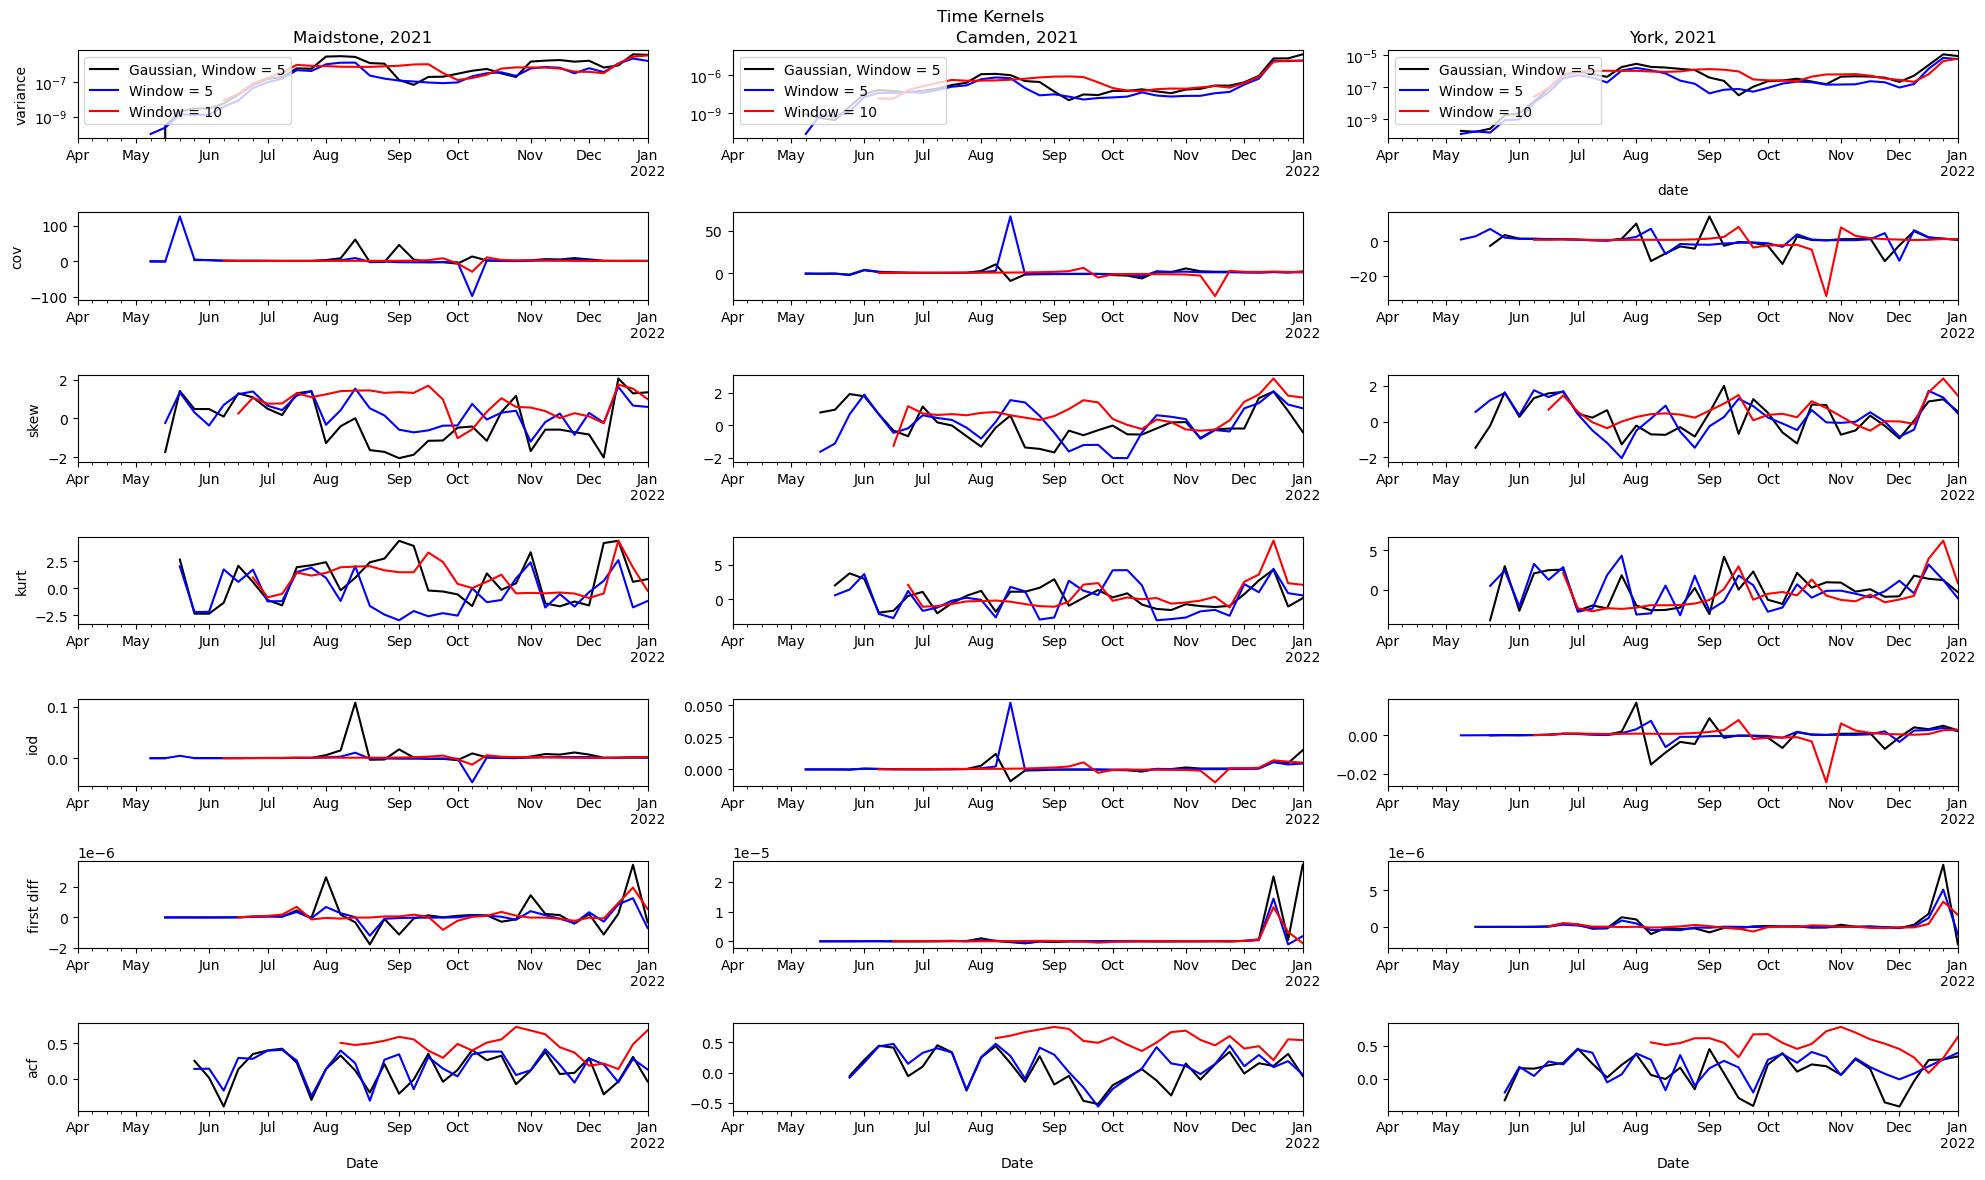

In [85]:
fig, axs = plt.subplots(nrows=len(ews_521_u.keys()),ncols=3,figsize=(20,12))
for i, stat in enumerate(ews_521_u.keys()):
    stat_data = ews_521_u[stat]
    y_data = stat_data['Maidstone']
    stat_data = ews_1021_u[stat]
    x_data = stat_data['Maidstone']
    stat_data = ews_521_g[stat]
    z_data = stat_data['Maidstone']
    if (stat == "variance"):
        z_data.plot(ax=axs[i,0],logy=True,color='black',label='Gaussian, Window = 5')
        y_data.plot(ax=axs[i,0],logy=True,color='blue',label='Window = 5')
        x_data.plot(ax=axs[i,0],logy=True,color='red',label='Window = 10')
        axs[i,0].legend()
        axs[i,0].set_title('Maidstone, 2021')
    else:
        z_data.plot(ax=axs[i,0],color='black')
        y_data.plot(ax=axs[i,0],color='blue')
        x_data.plot(ax=axs[i,0],color='red')
    axs[i,0].set_ylabel(stat)
    axs[i,0].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_521_u.keys()):
    stat_data = ews_521_u[stat]
    y_data = stat_data['Camden']
    stat_data = ews_1021_u[stat]
    x_data = stat_data['Camden']
    stat_data = ews_521_g[stat]
    z_data = stat_data['Camden']
    if (stat == "variance"):
        z_data.plot(ax=axs[i,1],logy=True,color='black',label='Gaussian, Window = 5')
        y_data.plot(ax=axs[i,1],logy=True,color='blue',label='Window = 5')
        x_data.plot(ax=axs[i,1],logy=True,color='red',label='Window = 10')
        axs[i,1].legend()
        axs[i,1].set_title('Camden, 2021')
    else:
        z_data.plot(ax=axs[i,1],color='black')
        y_data.plot(ax=axs[i,1],color='blue')
        x_data.plot(ax=axs[i,1],color='red')
    axs[i,1].xaxis.label.set_visible(False)
for i, stat in enumerate(ews_521_u.keys()):
    stat_data = ews_521_u[stat]
    y_data = stat_data['York']
    stat_data = ews_1021_u[stat]
    x_data = stat_data['York']
    stat_data = ews_521_g[stat]
    z_data = stat_data['York']
    if (stat == "variance"):
        z_data.plot(ax=axs[i,2],logy=True,color='black',label='Gaussian, Window = 5')
        y_data.plot(ax=axs[i,2],logy=True,color='blue',label='Window = 5')
        x_data.plot(ax=axs[i,2],logy=True,color='red',label='Window = 10')
        axs[i,2].legend()
        axs[i,2].set_title('York, 2021')
    else:
        z_data.plot(ax=axs[i,2],color='black')
        y_data.plot(ax=axs[i,2],color='blue')
        x_data.plot(ax=axs[i,2],color='red')
        axs[i,2].xaxis.label.set_visible(False)

for i in range(3):
    axs[len(axs)-1,i].set_xlabel("Date")
    axs[len(axs)-1,i].xaxis.label.set_visible(True)
fig.suptitle('Time Kernels')
fig.tight_layout()
plt.savefig("Figures/2021time.pdf",dpi=2400,bbox_inches='tight')
plt.show()